# Access to ECCO V4r4 Datasets on a Local Machine

imported on: **2023-09-14**

<p>This notebook is from a different repository in NASA's PO.DAAC, ECCO.</p>

> The original source for this document is [https://github.com/podaac/ECCO/blob/main/Data_Access/local_bulk_download_and_open_in_py3.ipynb](https://github.com/podaac/ECCO/blob/main/Data_Access/local_bulk_download_and_open_in_py3.ipynb)

*Duped+slightly modified version of the s3 access ipynb. Tested on JPL-issued macbook and my linux box. It starts by setting up a most trusted strategy for batch downloads behind URS ussing curl/wget. Will attempt to add line(s) to your netrc file if needed btw; then it writes your urs cookies to a local file that should effectively "pre-authenticate" future download sessions for those sub domains.*

# Download ECCO data to local disk & access from Python 3

This notebook is aimed at users who prefer to download the ECCO V4r4 data and analyze their content using local resources, as opposed to in the cloud.

<img src="https://podaac.jpl.nasa.gov/sites/default/files/mission_themes/featured_image/%20Estimating-the-Circulation-and-Climate-of-the-Ocean-ECCO-opt2.jpg" />

The notebook focuses on the 0.5-degree, monthly sea surface height grids from ECCO V4r4 ([10.5067/ECG5D-SSH44](https://doi.org/10.5067/ECG5D-SSH44)). All data files for the collection are downloaded to local disk in their native archive file format -- 312 total files in netCDF4 format. The notebook concludes by loading the whole gridded time series into Python with *xarray*.

## Quick Start

**A key takeaway in this notebook...** [follow these instructions on the Earthdata Wiki](https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget?src=contextnavpagetreemode) to authenticate and store your URS cookies in a local file. You can batch download really efficiently this way, effectively "pre-authenticated" through your previous session.    

Avoid lines that begin with `%` or `%%` in code cells. Those are IPython "magic functions" that tell a line or cell to evaluate in some special mode like by bash instead of py3.

### Configure your *.netrc* file

Good idea to back up your existing netrc file, if you have one. And while youre at it check for these entries because they might exist in there already:

In [1]:
%cp ~/.netrc ~/bak.netrc

%cat ~/.netrc | grep '.earthdata.nasa.gov' | cut -f-5 -d" "

machine urs.earthdata.nasa.gov login jmcnelis password
machine uat.urs.earthdata.nasa.gov login jmcnelis password
machine opendap.earthdata.nasa.gov login jmcnelis password


>Add entries to your netrc for these two *earthdata.nasa.gov* sub domains, at a minimum:
>```
machine urs.earthdata.nasa.gov login jmcnelis password ***
machine opendap.earthdata.nasa.gov login jmcnelis password ***
>```
>and replace `jmcnelis` and `***` with your Earthdata Login *username* and *password*, respectively...

Replace `jmcnelis` and `***` with your Earthdata *username* and *password*, and then run the cell to _append_ these two lines to your netrc file, if one exists. Otherwise write them to a new one. (all set up by `-a`)

In [2]:
%%file -a ~/.netrc
machine urs.earthdata.nasa.gov login jmcnelis password ***
machine opendap.earthdata.nasa.gov login jmcnelis password ***

Appending to /Users/jmcnelis/.netrc


Dump the netrc again sans passwords to confirm that it worked:

In [3]:
!cat ~/.netrc | grep '.earthdata.nasa.gov' | cut -f-5 -d" "

machine urs.earthdata.nasa.gov login jmcnelis password
machine uat.urs.earthdata.nasa.gov login jmcnelis password
machine opendap.earthdata.nasa.gov login jmcnelis password
machine urs.earthdata.nasa.gov login jmcnelis password
machine opendap.earthdata.nasa.gov login jmcnelis password


Finally, you need to make sure to limit access to the netrc file because it stores your plain text password. Simple on MacOS and Linux:

In [4]:
!chmod 0600 ~/.netrc

No outputs expected.

### Download a sample data file, get your URS cookies, and write them to a local file

Now I'll download a random file that's protected by URS/Earthdata Login authentication so that I can grab my URS cookies.

I chose to download a file containing ECCO grid geometries for the 0.5-degree latitude/longitude grid. It's small and it may prove useful for downstream analysis of the SSH data. (Again, any protected data file will work.)

In [1]:
%%bash
wget --no-verbose \
     --no-clobber \
     --load-cookies ~/.urs_cookies \
     --save-cookies ~/.urs_cookies \
     --keep-session-cookies \
     https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc

I used *--quiet* mode so wget would not dump tons of garbage into the notebook. Confirm that the cookies file exists in your home directory:

In [6]:
!ls ~/.urs_cookies

/Users/jmcnelis/.urs_cookies


And see if the file downloaded successfully to double-confirm it worked as expected (and be aware that the *ncdump* output is truncated to the first 50 lines):

In [7]:
!ncdump -h GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc | head -25

netcdf GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg {
dimensions:
	Z = 50 ;
	latitude = 360 ;
	longitude = 720 ;
	nv = 2 ;
variables:
	float Z(Z) ;
		Z:axis = "Z" ;
		Z:bounds = "Z_bnds" ;
		Z:comment = "Non-uniform vertical spacing." ;
		Z:coverage_content_type = "coordinate" ;
		Z:long_name = "depth of grid cell center" ;
		Z:positive = "up" ;
		Z:standard_name = "depth" ;
		Z:units = "m" ;
	float latitude(latitude) ;
		latitude:axis = "Y" ;
		latitude:bounds = "latitude_bnds" ;
		latitude:comment = "uniform grid spacing from -89.75 to 89.75 by 0.5" ;
		latitude:coverage_content_type = "coordinate" ;
		latitude:long_name = "latitude at grid cell center" ;
		latitude:standard_name = "latitude" ;
		latitude:units = "degrees_north" ;
	float longitude(longitude) ;


**And that's it!** You should now be able to use *wget* and *curl* to download URS-protected data from PODAAC cloud without providing your creds each time.

### Prepare a list of files to download

Now the only step that remains is to get a list of URLs to pass to *wget* or *curl* for downloading. There's a lot of ways to do this -- even more so for ECCO V4r4 data because the files/datasets follow well-structured naming conventions -- but we will rely on Earthdata Search to do this from the browser for the sake of simplicity.

**1. Find the collection/dataset of interest in Earthdata Search.**

Start from this [complete list of ECCO collections](https://search.earthdata.nasa.gov/portal/podaac-cloud/search?fpj=ECCO) in Earthdata Search (79 in total), and refine the results until you see your dataset of interest.
In this case we want [monthly sea surface height grids](https://search.earthdata.nasa.gov/portal/podaac-cloud/search/granules?p=C1990404799-POCLOUD) provided at 0.5-degree cell resolution on an interpolated latitude/longitude grid.

**2. Pick your collection, then click the green *Download All* button on the next page.**

Click the big green button identified by the red arrow/box in the screenshot below.

<img src="resources/edsc1.png" width="70%" />

That will add all the granules in the collection to your "shopping cart" and then redirect you straight there and present you with the available options for customizing the data prior to download. We will ignore those because they're mostly in active development and because we want to download all data in the collection.

<img src="resources/edsc2.png" width="70%" />
<center><i>The screenshot above shows the download customization interface (i.e. "shopping cart")</i></center>

**3. Click *Download Data* to get your list of download urls (bottom-left, another green button)**

The *Download Data* button takes you to one final page that provides the list of urls from which to download the files matching your search parameters and any customization options that you selected in the steps that followed. This page will be retained in your User History in case you need to return to it later.

<img src="resources/edsc3.png" width="70%" />

There are several ways that you could get the list of urls into a text file that's accessible from Jupyter or your local shell. I simply clicked the save button in my browser and downloaded them as a text file to a subdirectory called *resources* inside this workspace. (You could also copy them into a new notebook cell and write them to a file like we did with the netrc file above.)

### Download files in a batch with GNU *Wget*

I find *wget* options to be convenient and easy to remember. There are only a handful that I use with any regularity.

The most important wget option for our purpose is set by the `-i` argument, which takes a path to the input text file containing our download urls. Another nice feature of wget is the ability to continue downloads where you left of during a previously-interuppted download session. That option is turned on by passing the `-c` argument.

Now run wget against a list of files retrieve from Earthdata Search and see what happens.

In [8]:
!ls resources/*.txt

resources/5237392644-download.txt


Go ahead and create a *data/* directory to keep the downloaded files, and then start the downloads into that location by including the `-P` argument:

In [9]:
%%bash

mkdir -p data

wget --no-verbose \
     --no-clobber \
     --continue \
     -i resources/5237392644-download.txt -P data/

Wait a long time if you have to... then count the number of netCDF files in the *data* directory:

In [10]:
!ls -1 data/*.nc | wc -l

     312


Add a folder for outputs, if needed:

In [11]:
!mkdir -p outputs/

Get a list of netCDF files at the *data* directory and print the count + the first filename in the list:

In [12]:
files = !ls data/*.nc

len(files), files[0]

(312, 'data/SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r4_latlon_0p50deg.nc')

This is the first time you'll need any Python in this notebook... Install Python 3 requirements (I am on version 3.8.)

In [27]:
#!conda install -c conda-forge numpy dask netCDF4 xarray, cartopy, ffmpeg
import xarray as xr
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import cartopy

Open the netCDFs as one multi-file dataset with *xarray*:

In [20]:
ds = xr.open_mfdataset(
    paths=files,
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    chunks={'latitude': 360, 'longitude': 720, 'time': 5}
)

ssh = ds.SSH

print(ssh)

<xarray.DataArray 'SSH' (time: 312, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(312, 360, 720), dtype=float32, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height anomaly
    standard_name:          sea_surface_height_above_geoid
    units:                  m
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              -1.8805772066116333
    valid_max:              1.4207719564437866


### Plot gridded *sea surface height* time series

But only the timesteps beginning in 2015:

In [21]:
ssh_after_201x = ssh[ssh['time.year']>=2015,:,:]
print(ssh_after_201x)

<xarray.DataArray 'SSH' (time: 36, latitude: 360, longitude: 720)>
dask.array<getitem, shape=(36, 360, 720), dtype=float32, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2017-12-16T06:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height anomaly
    standard_name:          sea_surface_height_above_geoid
    units:                  m
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              -1.8805772066116333
    valid_max:              1.4207719564437866


Plot the grid for the first time step using a Robinson projection. Define a helper function for consistency throughout the notebook:

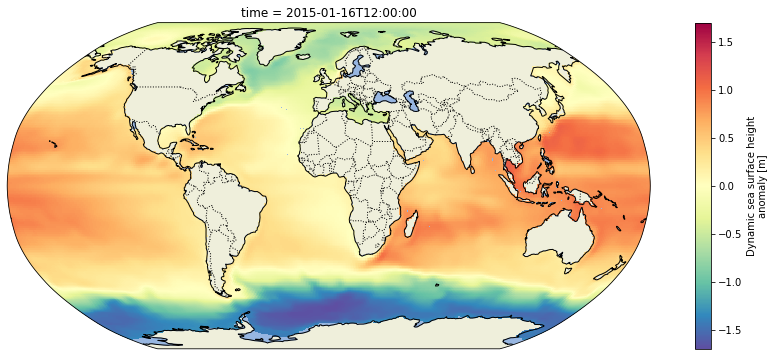

In [23]:
def make_figure(proj):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.add_feature(cfeat.LAND)
    ax.add_feature(cfeat.OCEAN)
    ax.add_feature(cfeat.COASTLINE)
    ax.add_feature(cfeat.BORDERS, linestyle='dotted')
    return fig, ax

fig, ax = make_figure(proj=ccrs.Robinson())

ssh_after_201x.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Spectral_r')

Now plot the whole time series (post-2010) in an animation and write it to an mp4 file called *ecco_monthly_ssh_grid_2015_to_x.mp4*:

In [29]:
def get_animation(var, cmap: str="Spectral_r"):
    """Get time series animation for input xarray dataset"""

    def draw_map(i: int, add_colorbar: bool):
        data = var[i]
        m = data.plot(ax=ax, 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=add_colorbar,
                      vmin=var.valid_min, 
                      vmax=var.valid_max,
                      cmap=cmap)
        plt.title(str(data.time.values)[:7])
        return m

    def init():
        return draw_map(0, add_colorbar=True)
    
    def animate(i):
        return draw_map(i, add_colorbar=False)

    return init, animate

Now make the animation using the function:

In [ ]:
fig, ax = make_figure(proj=ccrs.Robinson())

init, animate = get_animation(ssh_after_201x)

ani = animation.FuncAnimation(fig=fig, 
                              func=animate, 
                              frames=ssh_after_201x.time.size, 
                              init_func=init, 
                              interval=0.2, 
                              blit=False, 
                              repeat=False)

# Now save the animation to an MP4 file:
ani.save('outputs/ecco_monthly_ssh_grid_2015_to_x.mp4', writer=animation.FFMpegWriter(fps=8))

plt.close(fig)

Render the animation in the ipynb:

In [ ]:
#HTML(ani.to_html5_video())